# Imports

In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torchvision

from argparse import ArgumentParser   
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

from hcpinnseikonal.utils import *
from hcpinnseikonal.model import *
from hcpinnseikonal.train3dwell import *
from hcpinnseikonal.plot import *
from hcpinnseikonal.arguments import *

args = parser.parse_args([])

args.use_wandb='n'
args.project_name='GFATT_PINNs-21-3d-field'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_randomPINNs'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder
    
# plt.style.use("~/science.mplstyle")

{'lateral_spacing': 0.01, 'vertical_spacing': 0.01, 'max_offset': 5.0, 'max_depth': 1.0, 'rec_spacing': 10, 'sou_spacing': 10, 'num_epochs': 250, 'num_neurons': 20, 'num_layers': 10, 'learning_rate': 0.001, 'model_type': 'seam', 'data_type': 'full', 'middle_shot': 'n', 'until_cmb': 'n', 'earth_scale': 'n', 'scale_factor': 10, 'reduce_after': 15, 'seed': 123, 'initialization': 'varianceScaling', 'plotting_factor': 1, 'rescale_plot': 'n', 'depth_shift': 'n', 'tau_multiplier': 3.0, 'initial_velocity': 4, 'zid_source': 5, 'zid_receiver': 0, 'explode_reflector': 'n', 'field_synthetic': 'n', 'v_multiplier': 3, 'activation': 'elu', 'num_points': 1.0, 'irregular_grid': 'n', 'xid_well': 5, 'last_vmultiplier': 5, 'v_units': 'unitless', 'well_depth': None, 'exp_function': 'n', 'exp_factor': 1.0, 'exclude_topo': 'n', 'exclude_well': 'n', 'exclude_source': 'n', 'loss_function': 'mse', 'station_factor': 1.0, 'event_factor': 1.0, 'checker_size': 5.0, 'tau_act': 'None', 'empty_middle': 'n', 'factoriza

# Random Field

In [2]:
import torch
import math

from timeit import default_timer


class GaussianRandomField(object):

    def __init__(self, dim, size, alpha=2, tau=3, sigma=None, boundary="periodic", device=None):

        self.dim = dim
        self.device = device

        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.dim))

        k_max = size//2

        if dim == 1:
            k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                           torch.arange(start=-k_max, end=0, step=1, device=device)), 0)

            self.sqrt_eig = size*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0] = 0.0

        elif dim == 2:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,1)

            k_x = wavenumers.transpose(0,1)
            k_y = wavenumers

            self.sqrt_eig = (size**2)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0] = 0.0

        elif dim == 3:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,size,1)

            k_x = wavenumers.transpose(1,2)
            k_y = wavenumers
            k_z = wavenumers.transpose(0,2)

            self.sqrt_eig = (size**3)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2 + k_z**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0,0] = 0.0

        self.size = []
        for j in range(self.dim):
            self.size.append(size)

        self.size = tuple(self.size)

    def sample(self, N):

        coeff = torch.randn(N, *self.size, dtype=torch.cfloat, device=self.device)
        coeff = self.sqrt_eig * coeff

        return torch.fft.ifftn(coeff, dim=list(range(-1, -self.dim - 1, -1))).real

In [ ]:
# Resolution
s = 128

# Number of solutions to generate
N = 500

#Set up 2d GRF with covariance parameters
random_field = GaussianRandomField(2, s, alpha=2.5, tau=7, device='cuda')

# Sample random feilds
samples = random_field.sample(N) + 5
 
# Plot
for i in range(N//100):
    plot_section(samples[i,:,:].detach().cpu().numpy(), 'samples_'+str(i)+'_.pdf', 
                 save_dir='./', aspect='auto')

In [ ]:
def plot_images_grid(x: torch.tensor, export_img, title: str = '', nrow=8, padding=2, normalize=False, pad_value=0):
    """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""

    grid = make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
    npgrid = grid.cpu().numpy()

    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if not (title == ''):
        plt.title(title)

    plt.savefig(export_img, bbox_inches='tight', pad_inches=0.1)
    plt.show() 

# Numpy2Image

In [ ]:
from PIL import Image
import matplotlib.image

def float2rgb(x):
    
    x = (x - x.min())
    
    x = x / x.max()
    
    return 255 * x 

from pathlib import Path
Path('../data/random_fields/samples').mkdir(parents=True, exist_ok=True)

for i in range(N):

    # # Save array as images with Pillow
    # im = Image.fromarray(float2rgb(samples[i,:,:]).detach().cpu().numpy().astype(np.uint8))
    # im.save('../data/random_fields/samples_'+str(i)+'.jpg')
    
    # With Matplotlib
    matplotlib.image.imsave('../data/random_fields/samples/samples_'+str(i)+'.jpg', samples[i,:,:].detach().cpu().numpy())

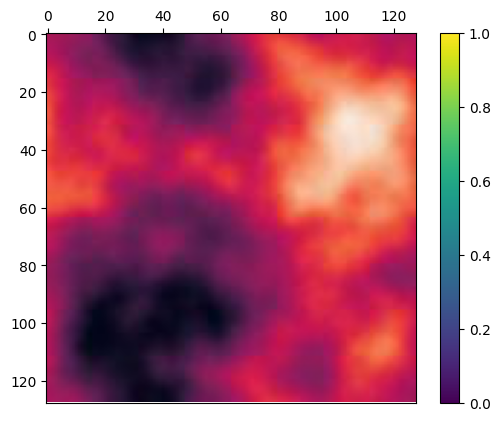

torch.Size([3, 128, 128])

In [3]:
# data_dir = 'Cat_Dog_data/train'
datadir = '../data/random_fields/' 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(datadir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)

dataiter = iter(dataloader)

images, labels = next(dataiter)

plt.imshow(images[0].permute((1,2,0)))
plt.colorbar()
plt.show()

images[0].shape

# Dataset

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

# UNet

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        output = self.last(x)

        return output


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        block.append(nn.Dropout2d(p=0.15)) # edited
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

## Train

In [ ]:
import sys, os, time, glob, time, pdb
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device: ', device)

script_time = time.time()

def plot_losses(running_train_loss, running_val_loss, train_epoch_loss, val_epoch_loss, epoch):
    fig = plt.figure(figsize=(16,16))
    fig.suptitle('loss trends', fontsize=20)
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ax1.title.set_text('epoch train loss VS #epochs')
    ax1.set_xlabel('#epochs')
    ax1.set_ylabel('epoch train loss')
    ax1.plot(train_epoch_loss)
    
    ax2.title.set_text('epoch val loss VS #epochs')
    ax2.set_xlabel('#epochs')
    ax2.set_ylabel('epoch val loss')
    ax2.plot(val_epoch_loss)
 
    ax3.title.set_text('batch train loss VS #batches')
    ax3.set_xlabel('#batches')
    ax3.set_ylabel('batch train loss')
    ax3.plot(running_train_loss)

    ax4.title.set_text('batch val loss VS #batches')
    ax4.set_xlabel('#batches')
    ax4.set_ylabel('batch val loss')
    ax4.plot(running_val_loss)
    
    plt.savefig(os.path.join('./','losses_{}.png'.format(str(epoch + 1).zfill(2))))

# defining the model
model = UNet(n_classes = 1, depth = 4, padding = True).to(device) # try decreasing the depth value if there is a memory error

train_epoch_loss = []
val_epoch_loss = []
running_train_loss = []
running_val_loss = []
epochs_till_now = 0

lr = 1e-5
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)
loss_fn = nn.MSELoss()

log_interval = 20
epochs = 100

for epoch in range(epochs_till_now, epochs_till_now+epochs):
    print('\n===== EPOCH {}/{} ====='.format(epoch + 1, epochs_till_now + epochs))    
    print('\nTRAINING...')
    epoch_train_start_time = time.time()
    model.train()
    for batch_idx, (imgs, noisy_imgs) in enumerate(train_loader):
        batch_start_time = time.time()
        imgs = imgs.to(device)
        noisy_imgs = noisy_imgs.to(device)

        optimizer.zero_grad()
        out = model(noisy_imgs)

        loss = loss_fn(out, imgs)
        running_train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        if (batch_idx + 1)%log_interval == 0:
            batch_time = time.time() - batch_start_time
            m,s = divmod(batch_time, 60)
            print('train loss @batch_idx {}/{}: {} in {} mins {} secs (per batch)'.format(str(batch_idx+1).zfill(len(str(len(train_loader)))), len(train_loader), loss.item(), int(m), round(s, 2)))

    train_epoch_loss.append(np.array(running_train_loss).mean())

    epoch_train_time = time.time() - epoch_train_start_time
    m,s = divmod(epoch_train_time, 60)
    h,m = divmod(m, 60)
    print('\nepoch train time: {} hrs {} mins {} secs'.format(int(h), int(m), int(s)))

    print('\nVALIDATION...')
    epoch_val_start_time = time.time()
    model.eval()
    with torch.no_grad():
        for batch_idx, (imgs, noisy_imgs) in enumerate(val_loader):

            imgs = imgs.to(device)
            noisy_imgs = noisy_imgs.to(device)

            out = model(noisy_imgs)
            loss = loss_fn(out, imgs)

            running_val_loss.append(loss.item())

            if (batch_idx + 1)%log_interval == 0:
                print('val loss   @batch_idx {}/{}: {}'.format(str(batch_idx+1).zfill(len(str(len(val_loader)))), len(val_loader), loss.item()))

    val_epoch_loss.append(np.array(running_val_loss).mean())

    epoch_val_time = time.time() - epoch_val_start_time
    m,s = divmod(epoch_val_time, 60)
    h,m = divmod(m, 60)
    print('\nepoch val   time: {} hrs {} mins {} secs'.format(int(h), int(m), int(s)))

    plot_losses(running_train_loss, running_val_loss, train_epoch_loss, val_epoch_loss,  epoch)   

    torch.save({'model_state_dict': model.state_dict(), 
                'losses': {'running_train_loss': running_train_loss, 
                           'running_val_loss': running_val_loss, 
                           'train_epoch_loss': train_epoch_loss, 
                           'val_epoch_loss': val_epoch_loss}, 
                'epochs_till_now': epoch+1}, 
                os.path.join('./', 'model{}.pth'.format(str(epoch + 1).zfill(2))))

total_script_time = time.time() - script_time
m, s = divmod(total_script_time, 60)
h, m = divmod(m, 60)
print(f'\ntotal time taken for running this script: {int(h)} hrs {int(m)} mins {int(s)} secs')
  
print('\nFin.')

# AutoEncoder

In [ ]:
from typing import Union, Optional, TypeVar, Generic, Dict, List, Type, Tuple

def make_MLP(din, dout, hidden=None, nonlin=nn.ELU, output_nonlin=None, bias=True, output_bias=None):
    '''
    :param din: int
    :param dout: int
    :param hidden: ordered list of int - each element corresponds to a FC layer with that width (empty means network is not deep)
    :param nonlin: str - choose from options found in get_nonlinearity(), applied after each intermediate layer
    :param output_nonlin: str - nonlinearity to be applied after the last (output) layer
    :return: an nn.Sequential instance with the corresponding layers
    '''

    if hidden is None:
        hidden = []

    if output_bias is None:
        output_bias = bias

    flatten = False
    reshape = None

    if isinstance(din, (tuple, list)):
        flatten = True
        din = int(np.product(din))
    if isinstance(dout, (tuple, list)):
        reshape = dout
        dout = int(np.product(dout))

    nonlins = [nonlin] * len(hidden) + [output_nonlin]
    biases = [bias] * len(hidden) + [output_bias]
    hidden = din, *hidden, dout

    layers = []
    if flatten:
        layers.append(nn.Flatten())

    for in_dim, out_dim, nonlin, bias in zip(hidden, hidden[1:], nonlins, biases):
        print(in_dim, out_dim)
        layer = nn.Linear(in_dim, out_dim, bias=bias)
        layers.append(layer)
        if nonlin is not None:
            layers.append(nonlin())

    if reshape is not None:
        layers.append(Reshaper(reshape))


    net = nn.Sequential(*layers)

    net.din, net.dout = din, dout
    
    print(net)
    
    return net

class Reshaper(nn.Module): # by default flattens
    def __init__(self, dout=(-1,)):
        super().__init__()

        self.dout = dout


    def extra_repr(self):
        return f'out={self.dout}'


    def forward(self, x):
        B = x.size(0)
        return x.view(B, *self.dout)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 1,
                 pool: Optional[str] = None, unpool: Optional[str] = None, pool_size: int = 2,
                 nonlin: Optional[Type[nn.Module]] = nn.ELU, norm: Optional[str] = 'batch', **kwargs):
        super().__init__()
        self.unpool = None if unpool is None else nn.Upsample(scale_factor=pool_size, mode=unpool)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, **kwargs)
        self.pool = None if pool is None \
            else (nn.MaxPool2d(pool_size) if pool == 'max' else nn.AvgPool2d(pool_size))
        if norm == 'batch':
            self.norm = nn.BatchNorm2d(out_channels)
        elif norm == 'instance':
            self.norm = nn.InstanceNorm2d(out_channels)
        elif norm == 'group':
            self.norm = nn.GroupNorm(8, out_channels)
        else:
            self.norm = None
        self.nonlin = nonlin()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        c = self.unpool(x) if self.unpool is not None else x
        c = self.conv(c)
        if self.pool is not None:
            c = self.pool(c)
        if self.norm is not None:
            c = self.norm(c)
        if self.nonlin is not None:
            c = self.nonlin(c)
        print('Pass')
        return c

class ConvAutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            ConvBlock( 3, 128, 5, 1, 2, pool='max', norm='group', nonlin=nn.ELU),
            ConvBlock(128, 128, 3, 1, 1, pool='max', norm='group', nonlin=nn.ELU),
            ConvBlock(128, 128, 3, 1, 1, pool='max', norm='group', nonlin=nn.ELU),
            ConvBlock(128, 128, 3, 1, 1, pool='max', norm='group', nonlin=nn.ELU),
            ConvBlock(128, 128, 3, 1, 1, pool='max', norm='group', nonlin=nn.ELU),
            make_MLP((64, 8, 4), latent_dim**2, [2048, 1024], nonlin=nn.ELU),
        )

        self.decoder = nn.Sequential(
            make_MLP((12, 1, 4), latent_dim**2, [latent_dim*2, latent_dim*4], nonlin=nn.ELU),
            ConvBlock(128, 128, 3, 1, 1, unpool='bilinear', norm='group', nonlin=nn.ELU),
            ConvBlock(128, 128, 3, 1, 1, unpool='bilinear', norm='group', nonlin=nn.ELU),
            ConvBlock(128, 128, 3, 1, 1, unpool='bilinear', norm='group', nonlin=nn.ELU),
            ConvBlock(128, 128, 3, 1, 1, unpool='bilinear', norm='group', nonlin=nn.ELU),
            ConvBlock(128,  3, 3, 1, 1, unpool='bilinear', norm=None, nonlin=nn.Sigmoid),
        )

    def forward(self, x):
        print(x.shape)
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x.reshape(x.shape))
        return x

## AEs Training

In [ ]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./aes_img'):
    os.mkdir('./aes_img')


def to_img(x, C, H, W):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), C, H, W)
    return x


num_epochs = 100
learning_rate = 1e-3

C, H, W = 3, 256, 256

# # For non RGB values
# transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.ToTensor()])

batch_size = 128

# data_dir = 'Cat_Dog_data/train'
datadir = '../data/random_fields/' 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(datadir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

class AutoEncoder(nn.Module):
    def __init__(self, H, W):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(C * H * W, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, C * H * W)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AutoEncoder(H, W).cuda()

# model = ConvAutoEncoder().cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-5
)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda() 
        
        # Forward
        output = model(img)
        loss = criterion(output, img)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Log
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data, C, H, W)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

        torch.save(model.state_dict(), './sim_autoencoder.pth')

# Load

In [13]:
from hcpinnseikonal.model import *

# Dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,),(0.5,))
])

train_dataset = torchvision.datasets.ImageFolder('../data/random_fields/train/', transform=transform)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [39000, 1000])
test_set = torchvision.datasets.ImageFolder('../data/random_fields/test/', transform=transform)

# Dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

latent_dim = 96

# Model
pretrained_filename = '../saved_models/random_fields/random_96/lightning_logs/version_3/checkpoints/epoch=28-step=4408.ckpt'
model = AutoEncoder.load_from_checkpoint(pretrained_filename)

# PytorchLightning Trainer
trainer = pl.Trainer(default_root_dir=os.path.join('../saved_models/random_fields/', f"random_{latent_dim}"), 
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=500, 
        callbacks=[ModelCheckpoint(save_weights_only=True),
                GenerateCallback(get_train_images(8), every_n_epochs=10),
                LearningRateMonitor("epoch")])
trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

# Inference
val_result = trainer.test(model, val_loader, verbose=False)
test_result = trainer.test(model, test_loader, verbose=False)

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

## CAEs Training

In [ ]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./caes_img'):
    os.mkdir('./caes_img')


def to_img(x, C, H, W):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), C, H, W)
    return x


num_epochs = 100
learning_rate = 1e-3

C, H, W = 3, 64, 64

# # For non RGB values
# transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.ToTensor()])

batch_size = 256

# data_dir = 'Cat_Dog_data/train'
datadir = '../data/random_fields/' 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(datadir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

model = ConvAutoEncoder(24).cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-5
)

for epoch in range(num_epochs):
    print(epoch)
    for data in dataloader:
        img, _ = data
        print(img.shape)
        # img = img.view(img.size(0), -1)
        img = Variable(img).cuda() 
        
        # Forward
        output = model(img)
        loss = criterion(output, img)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Log
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data, C, H, W)
        save_image(pic, './caes_img/image_{}.png'.format(epoch))

        torch.save(model.state_dict(), './sim_autoencoder.pth')

# VariationalAutoEncoder

In [ ]:
class BaseVariationalAutoEncoder(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVariationalAutoEncoder, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass
    
class VariationalAutoEncoder(BaseVariationalAutoEncoder):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [ ]:
hidden_size = 28
batch_size = 5
channels = 3
height = width = 64
original_shape = (batch_size, channels, height, width)
inp = torch.rand(*original_shape)
model = ConvolutionalVariationalAutoEncoder(channels, height, width, 0.01, hidden_size, 1, batch_size)

mu, log_var, output = model(inp)

assert mu.shape == (batch_size, hidden_size)
assert log_var.shape == (batch_size, hidden_size)
# assert output.shape == 

In [ ]:
from pytorch_lightning import Trainer
from models import vae_models
from config import config
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import os

def make_model(config):
    model_type = config.model_type
    model_config = config.model_config

    if model_type not in vae_models.keys():
        raise NotImplementedError("Model Architecture not implemented")
    else:
        return vae_models[model_type](**model_config.dict())


if __name__ == "__main__":
    model = make_model(config)
    train_config = config.train_config
    logger = TensorBoardLogger(**config.log_config.dict())
    trainer = Trainer(**train_config.dict(), logger=logger,
                      callbacks=LearningRateMonitor())
    if train_config.auto_lr_find:
        lr_finder = trainer.tuner.lr_find(model)
        new_lr = lr_finder.suggestion()
        print("Learning Rate Chosen:", new_lr)
        model.lr = new_lr
        trainer.fit(model)
    else:
        trainer.fit(model)
    if not os.path.isdir("./saved_models"):
        os.mkdir("./saved_models")
    trainer.save_checkpoint(
        f"saved_models/{config.model_type}_alpha_{config.model_config.alpha}_dim_{config.model_config.hidden_size}.ckpt")

## VAEs Training